# Classifying Suicidality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import re
from tqdm.auto import tqdm
from utility import clean_reddit_posts, extract_case_features, extract_linguistic_features

# Traditional Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from scipy.sparse import hstack, csr_matrix



# Determinism
random_seed = 42

np.random.seed(random_seed)


%load_ext autoreload
%autoreload 2

c:\Users\Ezra\OneDrive - De La Salle University - Manila\Documents\DLSU\3rd_Year\Term_2\STINTSY\Notebooks\stintsy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("cleaned_suicidality_dataset.csv", keep_default_na=False, index_col=0)

df.head()

,title,post,label,has_post,text,text_cleaned,first_person_singular,first_person_plural,absolutist_count,negative_emotion,death_related,past_tense,exclamation_count,question_count,upper_word_count,upper_word_ratio,has_positive_emoji,has_negative_emoji,has_crying_emoji,text_traditional
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal,1,I'm looking for a girl I've met at the Polish ...,I'm looking for a girl I've met at the Polish ...,27,2,0,0,0,3,1,1,4,0.017391,0,0,0,i'm looking for a girl i've met at the polish ...
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal,1,I got a guy kicked off a domestic flight today...,I got a guy kicked off a domestic flight today...,15,3,0,0,0,5,0,1,1,0.004950,0,0,0,i got a guy kicked off a domestic flight today...
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal,1,"My youngest got in school suspension, I’m so p...","My youngest got in school suspension, I’m so p...",4,2,2,0,0,0,0,0,4,0.050000,0,0,0,"my youngest got in school suspension, i’m so p..."
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal,1,"I'm a cashier who switched from ""sir/mam"" to ""...","I'm a cashier who switched from ""sir/mam"" to ""...",55,4,9,0,0,2,0,0,0,0.000000,1,0,0,"i'm a cashier who switched from ""sir/mam"" to ""..."
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal,1,My whole class complimented me and didn’t real...,My whole class complimented me and didn’t real...,15,3,2,0,0,4,0,1,1,0.005435,1,0,0,my whole class complimented me and didn’t real...


In [3]:
dataset = df.drop(["label"], axis=1)
label = df["label"]

## Dataset Split
We will do a standard 80/20 split for train and test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, train_size=0.8, random_state=random_seed)

In [5]:
label_encoder = LabelEncoder()

# Label encoding target labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Mapping of labels to encoding
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

## Traditional Machine Learning Models

### Preprocessing
We first encoding the cleaned text data into a form the model can use.

In [6]:
# TF-IDF Encoding Text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
standard_scaler = StandardScaler()

# Trainset and Testset
train_linguistic_features = X_train.loc[:, "first_person_singular": "has_crying_emoji"]
train_text_traditional = X_train["text_traditional"]

test_linguistic_features = X_test.loc[:, "first_person_singular": "has_crying_emoji"]
test_text_traditional = X_test["text_traditional"]

# Encoding datasets
train_linguistic_encoded = csr_matrix(standard_scaler.fit_transform(train_linguistic_features))
test_linguistic_encoded = csr_matrix(standard_scaler.transform(test_linguistic_features))

train_text_encoded = vectorizer.fit_transform(train_text_traditional)
test_text_encoded = vectorizer.transform(test_text_traditional)

# Combined traditional
X_train_trad = hstack((train_text_encoded, train_linguistic_encoded))
X_test_trad = hstack((test_text_encoded, test_linguistic_encoded))

### Classification Baseline Accuracy

### Logistic Regression
Baseline model for classification

In [7]:
logreg = LogisticRegression(max_iter=1000, random_state=random_seed)
logreg.fit(X_train_trad, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [8]:
initial_accuracy = logreg.score(X_train_trad, y_train)
print(f"Accuracy on the training set is: {initial_accuracy*100:.2f}%")

Accuracy on the training set is: 96.22%


In [9]:
y_predicted = logreg.predict(X_train_trad)
report = classification_report(y_train, y_predicted)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      6551
           1       0.97      0.95      0.96      5829

    accuracy                           0.96     12380
   macro avg       0.96      0.96      0.96     12380
weighted avg       0.96      0.96      0.96     12380



### Hyperparameter Tuning

In [10]:
param_grid_logreg = {
    "penalty": ["l1", "l2"], # Lasso, Ridge, Elasticnet
    "C": np.logspace(-3, 3, 6) # Inverse of lambda
}

# Understand why these are the parameter grid to use.

In [ ]:
logreg_cv = GridSearchCV(LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed), param_grid=param_grid_logreg, cv=5, n_jobs=2, return_train_score=True, verbose=1)

logreg_cv.fit(X_train_trad, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
logreg_cv_results = pd.DataFrame(logreg_cv.cv_results_)
logreg_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.011166,0.000327,0.000000,0.000000,0.001000,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.166560,0.081238,0.004326,0.002290,0.001000,l2,"{'C': 0.001, 'penalty': 'l2'}",0.706381,0.727383,0.729402,0.714459,0.731018,0.721729,0.009649,6,0.724354,0.720113,0.720012,0.723647,0.722132,0.722052,0.001776
2,0.039091,0.006769,0.000000,0.000000,0.015849,l1,"{'C': 0.015848931924611134, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.203881,0.034695,0.001725,0.000266,0.015849,l2,"{'C': 0.015848931924611134, 'penalty': 'l2'}",0.819871,0.822698,0.828756,0.813409,0.826333,0.822213,0.005348,5,0.823506,0.825929,0.823910,0.825424,0.825525,0.824859,0.000963
4,0.013373,0.001829,0.000000,0.000000,0.251189,l1,"{'C': 0.25118864315095796, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.440740,0.029029,0.001993,0.000093,0.251189,l2,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.925687,0.922859,0.918417,0.923667,0.922456,0.922617,0.002377,4,0.932653,0.936288,0.934370,0.933865,0.933562,0.934148,0.001207
6,0.012483,0.002916,0.000000,0.000000,3.981072,l1,"{'C': 3.981071705534969, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.830200,0.099038,0.001682,0.000378,3.981072,l2,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.948708,0.949515,0.946688,0.945477,0.945477,0.947173,0.001663,1,0.984754,0.986268,0.985965,0.985561,0.986066,0.985723,0.000537
8,0.012742,0.002298,0.000000,0.000000,63.095734,l1,"{'C': 63.0957344480193, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.097028,0.060687,0.001800,0.000704,63.095734,l2,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.950323,0.941842,0.946284,0.943053,0.938207,0.943942,0.004106,2,0.999798,0.999899,0.999798,1.000000,0.999899,0.999879,0.000076


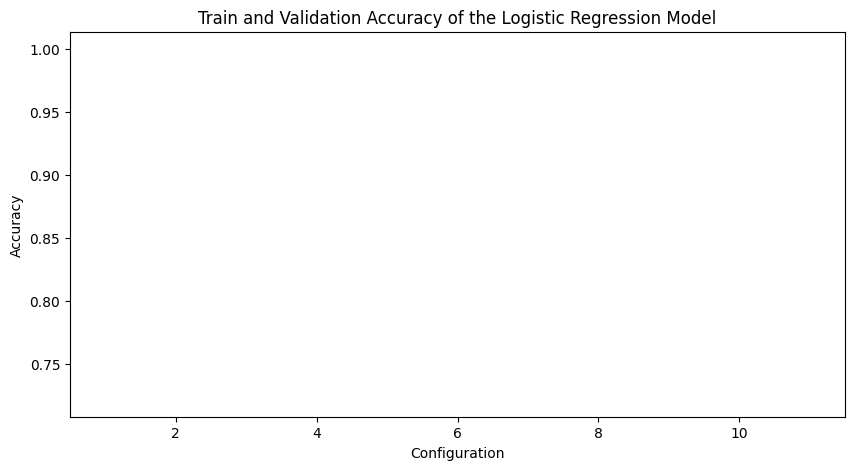

In [ ]:
train_scores = logreg_cv_results["mean_train_score"]
validation_scores = logreg_cv_results["mean_test_score"]

fig, ax = plt.subplots(figsize=[10,5])
ax.plot(train_scores, label="Train")
ax.plot(validation_scores, label="Validation")
ax.set_title("Train and Validation Accuracy of the Logistic Regression Model")
ax.set_xlabel("Configuration")
ax.set_ylabel("Accuracy")
plt.show()


In [ ]:
best_params = logreg_cv.best_params_
best_C, best_penalty = best_params["C"], best_params["penalty"]

In [ ]:
optimized_logreg = LogisticRegression(max_iter=1000, random_state=random_seed, C=best_C, penalty=best_penalty)
optimized_logreg.fit(X_train_trad, y_train)

c:\Users\Ezra\OneDrive - De La Salle University - Manila\Documents\DLSU\3rd_Year\Term_2\STINTSY\Notebooks\stintsy\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",np.float64(3.981071705534969)
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.

### Evaluating on the test set

In [ ]:
test_accuracy = optimized_logreg.score(X_test_trad, y_test)
print(f"Accuracy on the training set is: {test_accuracy*100:.2f}%")

Accuracy on the training set is: 94.90%


In [ ]:
y_predicted = optimized_logreg.predict(X_test_trad)
report = classification_report(y_test, y_predicted)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1650
           1       0.96      0.93      0.94      1446

    accuracy                           0.95      3096
   macro avg       0.95      0.95      0.95      3096
weighted avg       0.95      0.95      0.95      3096



### Error Analysis

In [ ]:
error_bool = y_predicted != y_test
y_test[error_bool].value_counts()

In [ ]:
X_test_trad[error_bool]